# Hiercarchical Logistic regression

This notebook showcases the *HiercarchicalLogisticRegression* that I made. This class computes the initialization for the ORCT, in the hope that it will yield to better results or faster convergence.
The work can be divided into 3 steps. In the first step the dataset is partitioned into clusters. In the second step, each cluster is assigned to a leaf in the ORCT model maximizing some "purity" metric. In the third step, a **Hierarchical Loogistic Regressor** is trained in order to force the ORCT to assign each sample to the corrensponding leaf.

### Preprocessing of the Dataset

This part loads a dataset in order to have some data on which run the algorithm

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import operator
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [2]:
SEED = 1234
name = "splice.csv"
DATASET_PATH = os.path.join("datasets", name)
df = pd.read_csv(DATASET_PATH, delimiter=";", header=0)
columns = list(df.columns)
X = df[columns[:-1]]
y = df[columns[-1]]
feature_names = columns[:-1]

In [3]:
print("Number of rows: {}\nShape: {}".format(len(df), df.shape))
print("The are {} columns".format(len(df.columns)))
print("\nDistinct values for 'Classes' column\n{}\n".format(df["Classes"].value_counts()))

Number of rows: 1594
Shape: (1594, 187)
The are 187 columns

Distinct values for 'Classes' column
2    834
0    384
1    376
Name: Classes, dtype: int64



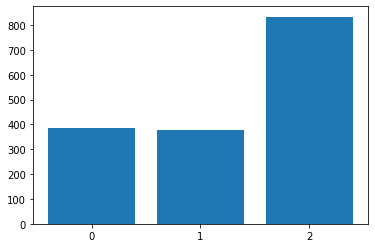

In [4]:
vals = y.unique()
vals.sort()
heights = [len(y[y==x]) for x in vals ]
vals = [str(x) for x in vals]
plt.bar(vals, heights)
plt.show()

The class 2 is more present than the other two classes, but the dataset can be considered fairly balanced.

## Find the best clustering
In order to find the parameters of the ORCT, we need to partition the dataset in different clusters. The number of leaves of the ORCT depends on its depth and it's always a power of two, since the ORCT is a binary tree. In this dataset we have 3 classes, and the closest power of 2 is 4, therefore we will have a 2-depth tree.
Three possible approaches are possible here:
* An unsupervised algorithm that outputs exatcly **n_leaves** cluster.
* An unsupervised algorithm that has no gaurantee on the number of cluster found.
* The original class division.

In the first case, an algorithm such as *KMeans* can be used. The advantage of this approach is that every leaf will have a cluster and therefore every branch node will participate in the classification task.The main drawback is that if the dataset has a lower number of classes, the division in exactly **n_leaves** cluster may be not effective since that kind of structure is not present in the data.<br>
In the second case, we just need to ensure that the number of cluster found is les than the number of wanted leaves. Since there is no gaurantee on the number of clusters found, this algorithm could output a number much smaller of **n_leaves**, maybe even smaller than of **n_classes**, and the ORCT will probably not perform really well. <br>
In the last case, we can use the original class division. In these way, no assumption on the input data is done and all the members of the same class are assigned to the same leaf. The drawback is that we are using less leaves in the case $n_{classes} < n_{leaves} $.<br>
The quality of a solution is measured with a **purity** metric, that tells how similar are the data points present in a cluster. This metric assumes known the original class of each sample. Since this is a classification task, we have this knowledge. <br>
I decided to use the **homogeneity score** $hs$. A clustering is very homogeneus if all of its clusters contain samples which are member of the same class. Note that $hs \in [0,1]$ . Values near one imply a very homogeneous clustering result. <br>
The following code uses some clustering algorithm that ensure to have **n_leaves** clusters. A solution with the original labeling is also used and compared to the clustering algorithm.<br>

In [5]:
X_std = X.copy()
X_std[feature_names] = StandardScaler().fit_transform(X[feature_names])
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=SEED)
classes = y.unique().tolist()
classes.sort() # sorted    

Sample weigthing.

In [6]:
occurences = [len(y_train[y_train==x]) for x in classes]
total_samples = sum(occurences)
sample_weight = np.zeros_like(y_train)
for class_index, n_occurr in zip(classes, occurences):
    sample_weight[y_train==class_index]=n_occurr
sample_weight = sample_weight/total_samples

The clustering estimators used are *Kmeans, Spectral Clustering, Agglomerative Clustering (with 4 different linkage types), and Birch*. All the clustering estimators are put in the same list *clustering_estimators*.

In [7]:
n_leaves = 4
n_clusters = n_leaves
clustering_estimators = []
params = dict(n_clusters=n_clusters, random_state=SEED)
kmeans = KMeans(**params)
clustering_estimators.append(kmeans)

# Spectral clustering not used since it gave looped

params = dict(n_clusters=n_clusters, linkage="single")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="ward")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="complete")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="average")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters)
birch = Birch(**params)
clustering_estimators.append(birch)



Fit every estimator and computes their homogeneity. In the code below the clustering algorithm that support *sample_weight* are instantiated with it. <br>
The homogeneity score is computed for each fitted estimator.The **find_best_estimator** function is used to find the best estimator given a certain metric. It assumes that the metric needs the real labels of the data, so that the original information embedded in the data points can be used. <br>
If the original labelling is used, its homogeneity would be of couse 1.

In [8]:
from src.cluster import find_best_estimator

for i in range(len(clustering_estimators)):
    try:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train, sample_weight=sample_weight)
    except:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train)

for estimator in clustering_estimators:
    print(estimator.__class__.__name__, homogeneity_score(y_train, estimator.labels_))
    
best_estimator = find_best_estimator(clustering_estimators, homogeneity_score, y_train)
print("The best estimator is {}".format(best_estimator))


/home/oscarpindaro/git_projects/optimization-project/src/cluster.py:271: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.prediction_type is "deterministic":
/home/oscarpindaro/git_projects/optimization-project/src/cluster.py:273: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.prediction_type is "probabilistic":


KMeans 0.27684999814353056
AgglomerativeClustering 0.0022374154879104663
AgglomerativeClustering 0.10784173404673172
AgglomerativeClustering 0.0022374154879104663
AgglomerativeClustering 0.0022374154879104663
Birch 0.13976558265285352
The best estimator is KMeans(n_clusters=4, random_state=1234)


/home/oscarpindaro/miniconda3/envs/decision_trees/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


## Find the best leaves assignment

Now we sould find the best leaves assignment. Now that we have divided the data in $n_{leaves}$ cluster, we should decide  which cluster is assigned to which leaf. The idea is to find an order such that, when two cluster are merged, a certain metric sould be maximized. This procedure is repeated recursively till only two mega-clusters with maximum metric value are found. <br>
This assignment is computed with a Depth-First Search Algorithm that checks every possible coupling. Since inside a couple the order of the clusters does not matter, and since there is no need to check permutations of couples for the same reason, the number of possible coupling is: <br>
$ {n \choose 2} {n-2 \choose 2} ... {4 \choose 2} / \frac n 2! = (n-1)*(n-3)...5*3$ <br>
**NB**: I think this formula is correct only for $n<8$, but i'm not super sure, probably it's a lower bound. <br><br>
Here the *completeness_score* is used. A clustering assignment satisfies completeness if all the data points of a given class belong to the same cluster. The closer the completeness is to 1, the more complete the clustering result. In this case, it looks like the best complete estimator was Birch.

In [9]:
from src.cluster import best_leaf_assignment
for estimator in clustering_estimators:
    assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=estimator.labels_, 
                                      true_labels=y_train, metric=completeness_score)
    print("For the estimator {}, the assignment {} has a score of {}".format(estimator.__class__.__name__,assignment, score))

For the estimator KMeans, the assignment [0, 1, 2, 3] has a score of 0.18260695983039052
For the estimator AgglomerativeClustering, the assignment [0, 3, 1, 2] has a score of 0.08778700261653409
For the estimator AgglomerativeClustering, the assignment [0, 2, 1, 3] has a score of 0.18418527760037742
For the estimator AgglomerativeClustering, the assignment [0, 3, 1, 2] has a score of 0.08778700261653409
For the estimator AgglomerativeClustering, the assignment [0, 3, 1, 2] has a score of 0.08778700261653409
For the estimator Birch, the assignment [0, 2, 1, 3] has a score of 0.26478933557964085


The true labelling will be of course complete.

In [10]:
assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=y_train, 
                                      true_labels=y_train, metric=completeness_score)
print("The true labelling has assignment {} with score {}".format(assignment, score))

The true labelling has assignment [0, 1, 2, 3] with score 1.0000000000000002


## Parameters Initialization
Now that the best estimator was found and the best leaf assignment was computed, we need to train the **Hierarchical Logistic Regressor**. This classifier is made of multiple logistic regressors, structured in a binary tree fashion. Every regressor is trained against a binary classification problem. If the label is zero, that means that the leaf that contains that sample is in the left subtree, otherwhise it's in the right subtree. If the tree has $n_{leaves}$, the number of logistic regressors that have to be trained are $n_{leaves}-1$. Every problem is independent, since the classification of a parent node has no effect on the classification of its childs. This is because all nodes know in advance where each sample belongs.

In [11]:
from src.cluster import HierarchicalLogisticRegression
HLR = HierarchicalLogisticRegression(n_classes=len(np.unique(y_train)), n_leaves=n_leaves, prediction_type="deterministic", random_state=0,
                                     logistic_params={"class_weight": "balanced"})

In [12]:
best = clustering_estimators[0]
best_accuracy = 0
i = 0
for estimator in clustering_estimators:
    """
    print(estimator)
    print(np.unique(estimator.labels_))
    for un in np.unique(estimator.labels_):
        print(len(estimator.labels_[estimator.labels_==un]))
    """
    assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=estimator.labels_, 
                                  true_labels=y_train, metric=completeness_score)
    HLR = HLR.fit(X_train.to_numpy(), y_train, cluster_labels=estimator.labels_, leaves_assignment=assignment)
    accuracy = HLR.score(X_test.to_numpy(), y_test)
    print("{} accuracy:{}".format(estimator, accuracy))
    if accuracy > best_accuracy:
        best = clustering_estimators[i]
        best_accuracy = accuracy
    i +=1
print("The best was {} with score {}".format(best, best_accuracy))

KMeans(n_clusters=4, random_state=1234) accuracy:0.07017543859649122
AgglomerativeClustering(linkage='single', n_clusters=4) accuracy:0.5238095238095238
AgglomerativeClustering(n_clusters=4) accuracy:0.706766917293233
AgglomerativeClustering(linkage='complete', n_clusters=4) accuracy:0.5238095238095238
AgglomerativeClustering(linkage='average', n_clusters=4) accuracy:0.5238095238095238
Birch(n_clusters=4) accuracy:0.706766917293233
The best was AgglomerativeClustering(n_clusters=4) with score 0.706766917293233


Now let's try to use the real labeling. It has much higher performances, because it has the most homogenous clustering and also the most complete. However, this may stuck the optimization of the ORCT in a local minima. Some tests should still be made.

In [16]:
assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=y_train, 
                                      true_labels=y_train, metric=completeness_score)
print("The true labelling has assignment {} with score {}".format(assignment, score))
HLR = HierarchicalLogisticRegression(n_classes=len(np.unique(y_train)),
                                     n_leaves=n_leaves, prediction_type="deterministic",
                                     random_state=0)
HLR = HLR.fit(X_train.to_numpy(), y_train, cluster_labels=y_train, leaves_assignment=assignment)
accuracy = HLR.score(X_test.to_numpy(), y_test)
print("Accuracy using true labellling: {}".format(accuracy))

The true labelling has assignment [0, 1, 2, 3] with score 1.0000000000000002
Accuracy using true labellling: 0.8796992481203008


0.8796992481203008